# Titanic - Machine Learning from Disaster

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

In [3]:
train_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_set.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

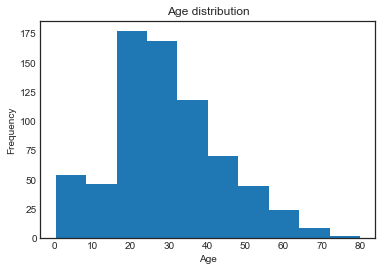

In [6]:
plt.hist(train_set['Age'].dropna())
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

## Data Preprocessing

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

In [8]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name):
        self.attribute_name = attribute_name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_name]

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [10]:
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Numerical Columns

In [11]:
train_set.loc[:,'SibSp'] + train_set.loc[:, 'Parch']

0      1
1      1
2      0
3      1
4      0
      ..
886    0
887    0
888    3
889    0
890    0
Length: 891, dtype: int64

In [12]:
class combineColumn(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        column_sum = (X['SibSp'] + X['Parch']).copy(deep = True)
        X['FamilySize'] = column_sum
        X.drop(['SibSp','Parch'], inplace = True, axis = 1)
        return X

In [13]:
test_set.columns.values


array(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [14]:
num_column = ['Age', 'SibSp', 'Parch', 'Fare']
num_pipeline = Pipeline([
    ("select columns", DataFrameSelector(num_column)),
    ('combine sib and parch', combineColumn()),
    ("imputer", SimpleImputer(strategy = 'median')),
    ('scale', StandardScaler())
])

In [15]:
num_pipeline.fit_transform(train_set)

array([[-0.56573646, -0.50244517,  0.05915988],
       [ 0.66386103,  0.78684529,  0.05915988],
       [-0.25833709, -0.48885426, -0.56097483],
       ...,
       [-0.1046374 , -0.17626324,  1.29942929],
       [-0.25833709, -0.04438104, -0.56097483],
       [ 0.20276197, -0.49237783, -0.56097483]])

In [16]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        self.most_frequent = {column: X[column].value_counts().index[0] for column in X}
        return self
    def transform(self, X, y = None):
        return X.fillna(self.most_frequent)

## Categorical Columns

In [17]:
cat_column = ['Pclass', 'Sex', 'Embarked']
cat_pipeline = Pipeline([
    ('select coloumns', DataFrameSelector(cat_column)),
    ('imputer', MostFrequentImputer()),
    ('encode', OneHotEncoder(sparse = False))
])

In [18]:
cat_pipeline.fit_transform(train_set)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [19]:
cat_pipeline_1 = Pipeline([
    ('select coloumns', DataFrameSelector(['Pclass', 'Sex', 'Embarked'])),
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encode', OneHotEncoder(sparse = False))
])

In [20]:
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer

In [21]:
final_pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [22]:
X_train = final_pipeline.fit_transform(train_set)

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer

In [24]:
def preprocessing_age_group(data):
    num_column = ['SibSp', 'Parch', 'Fare']
    num_pipeline = Pipeline([
        ('combine sib and parch', combineColumn()),
        ("imputer", SimpleImputer(strategy = 'median')),
        ('scale', StandardScaler())
    ])
    
    cat_column = ['Pclass', 'Sex', 'Embarked']
    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy = 'most_frequent')),
        ('encode', OneHotEncoder(sparse = False))
    ])
    
    age_column = ['Age']
    age_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy = 'median')),
        ('ordinal', KBinsDiscretizer(n_bins = 6, encode = 'ordinal')),
    ])
    
    final = ColumnTransformer([
    ('num', num_pipeline, num_column),
    ('cat', cat_pipeline, cat_column),
    ('ordinal', age_pipeline, age_column),
    ])
    
    return final.fit_transform(data)

In [25]:
# X_train = preprocessing_age_group(train_set)

In [26]:
y_train = train_set['Survived']

In [27]:
from sklearn.svm import SVC

In [28]:
svc_clf = SVC(gamma = 'auto')
svc_clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [29]:
from sklearn.model_selection import cross_val_score

## SVC

In [30]:
svc_clf_score = cross_val_score(svc_clf, X_train, y_train, cv = 10)

In [31]:
svc_clf_score.mean()

0.8226841448189763

## Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_clf_score = cross_val_score(rf_clf, X_train, y_train, cv = 10)
rf_clf_score.mean()

0.8047940074906366

## Feature Importance Based On Random Forest

In [33]:
rf_clf.fit(X_train, y_train)
for name, score in sorted(zip(num_column + cat_column, rf_clf.feature_importances_), key = lambda l: l[1], reverse = True):
    print(name, score)

Age 0.25979252301750777
SibSp 0.2509271956449586
Embarked 0.13016719771585814
Parch 0.07804676931129137
Sex 0.04872753101811762
Fare 0.030894006378336485
Pclass 0.013608454569897616


## Naive Bayes

In [34]:
from sklearn.naive_bayes import GaussianNB

GNB = GaussianNB()
GNB_score = cross_val_score(GNB, X_train, y_train, cv = 10)
GNB_score.mean()

0.79354556803995

## Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
lr_clf = LogisticRegression()
lr_clf_score = cross_val_score(lr_clf, X_train, y_train, cv = 10)
lr_clf_score.mean()

0.8002496878901372

## Voting

In [37]:
from sklearn.ensemble import VotingClassifier

In [38]:
voting_clf = VotingClassifier(estimators = [
    ('lr', lr_clf),
    ('rf', rf_clf)
], voting = 'hard')

In [39]:
voting_clf_score = cross_val_score(voting_clf, X_train, y_train, cv = 10)
voting_clf_score.mean()

0.8069912609238452

## AdaBoost

In [40]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(n_estimators = 50, random_state = 200)
ada_clf_score = cross_val_score(ada_clf, X_train, y_train, cv = 10)
ada_clf_score.mean()

0.811498127340824

## Male prediction

In [42]:
X_test = final_pipeline.fit_transform(test_set)
y_pred = svc_clf.predict(X_test)

In [50]:
Survived = pd.DataFrame({'Survived': y_pred})

In [62]:
result = pd.concat([test_set[['PassengerId']], Survived], axis = 1)

In [65]:
result.to_csv(r'C:\Users\zhong\Desktop\UOP\Titanic\titanic\result_dataframe.csv', header = True, index = False)